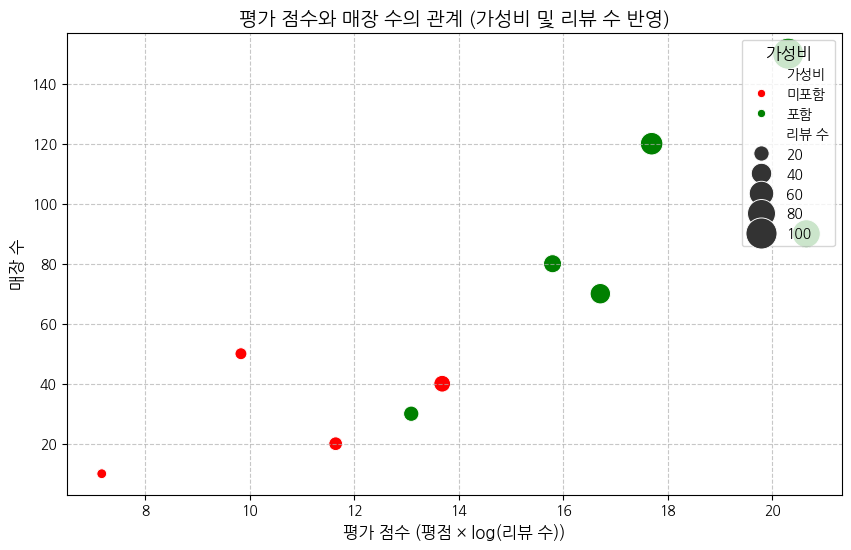

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import koreanize_matplotlib
# 데이터 준비 (예시)
data = {
    '평점': [4.1, 4.3, 4.5, 4.2, 4.6, 4.0, 4.4, 4.7, 4.2, 4.5],  # 평점 (0~5)
    '리뷰 수': [10, 20, 50, 15, 30, 5, 100, 80, 25, 40],  # 리뷰 수
    '매장 수': [50, 30, 120, 20, 80, 10, 150, 90, 40, 70],  # 매장 수
    '가성비': ['미포함', '포함', '포함', '미포함', '포함', '미포함', '포함', '포함', '미포함', '포함']  # 가성비 (범주형)
}
df = pd.DataFrame(data)

# 평가 점수 계산: 평점 × log(리뷰 수)
df['평가 점수'] = df['평점'] * np.log(df['리뷰 수'] + 1)  # log(0) 방지를 위해 +1

# 산점도 생성
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x='평가 점수', 
    y='매장 수', 
    size='리뷰 수',  # 점의 크기를 리뷰 수로 설정
    hue='가성비',  # 점의 색상을 가성비로 구분
    palette={'포함': 'green', '미포함': 'red'},  # 가성비 범주형 색상
    sizes=(50, 500),  # 점 크기 범위 조정
    data=df
)

# 그래프 스타일링
plt.title('평가 점수와 매장 수의 관계 (가성비 및 리뷰 수 반영)', fontsize=14)
plt.xlabel('평가 점수 (평점 × log(리뷰 수))', fontsize=12)
plt.ylabel('매장 수', fontsize=12)
plt.legend(title='가성비', fontsize=10, title_fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [4]:
import mysql.connector
import pandas as pd

# MySQL 데이터베이스 연결 함수
def execute_sql(query):
    try:
        # 데이터베이스 연결
        ojk = mysql.connector.connect(
            host="database-1.cnu82kme6p4d.ap-northeast-2.rds.amazonaws.com",
            port=3306,
            user="eda",
            password="ojk0707",
            database="ojk"
        )
        cursor = ojk.cursor()
        cursor.execute(query)
        result = cursor.fetchall()
        ojk.commit()
        print("쿼리 실행 성공")
        return result
    except mysql.connector.Error as err:
        print(f"에러: {err}")
        return None
    finally:
        cursor.close()
        ojk.close()

# 1. 상위 10개 역 (혼잡도 높은 순, spot 테이블에 존재하는 역만)
top_10_query = """
SELECT 
    sc.name AS StationName,
    AVG(
        COALESCE(sc.t1000_t1030, 0) + COALESCE(sc.t1030_t1100, 0) + COALESCE(sc.t1100_t1130, 0) + 
        COALESCE(sc.t1130_t1200, 0) + COALESCE(sc.t1200_t1230, 0) + COALESCE(sc.t1230_t1300, 0) + 
        COALESCE(sc.t1300_t1330, 0) + COALESCE(sc.t1330_t1400, 0) + COALESCE(sc.t1400_t1430, 0) + 
        COALESCE(sc.t1430_t1500, 0) + COALESCE(sc.t1500_t1530, 0) + COALESCE(sc.t1530_t1600, 0) + 
        COALESCE(sc.t1600_t1630, 0) + COALESCE(sc.t1630_t1700, 0) + COALESCE(sc.t1700_t1730, 0) + 
        COALESCE(sc.t1730_t1800, 0) + COALESCE(sc.t1800_t1830, 0) + COALESCE(sc.t1830_t1900, 0)
    ) / 18 AS AverageCongestion
FROM staion sc
INNER JOIN spot s ON sc.name = s.station
WHERE sc.day IN ('토요일', '일요일')
GROUP BY sc.name
ORDER BY AverageCongestion DESC
LIMIT 10;
"""
top_10_result = execute_sql(top_10_query)
print("상위 10개 역 (혼잡도 높은 순, spot 테이블에 존재하는 역만):")
for row in top_10_result:
    print(row)

# 2. 하위 10개 역 (혼잡도 낮은 순, 0 제외, spot 테이블에 존재하는 역만)
bottom_10_query = """
SELECT 
    sc.name AS StationName,
    AVG(
        COALESCE(sc.t1000_t1030, 0) + COALESCE(sc.t1030_t1100, 0) + COALESCE(sc.t1100_t1130, 0) + 
        COALESCE(sc.t1130_t1200, 0) + COALESCE(sc.t1200_t1230, 0) + COALESCE(sc.t1230_t1300, 0) + 
        COALESCE(sc.t1300_t1330, 0) + COALESCE(sc.t1330_t1400, 0) + COALESCE(sc.t1400_t1430, 0) + 
        COALESCE(sc.t1430_t1500, 0) + COALESCE(sc.t1500_t1530, 0) + COALESCE(sc.t1530_t1600, 0) + 
        COALESCE(sc.t1600_t1630, 0) + COALESCE(sc.t1630_t1700, 0) + COALESCE(sc.t1700_t1730, 0) + 
        COALESCE(sc.t1730_t1800, 0) + COALESCE(sc.t1800_t1830, 0) + COALESCE(sc.t1830_t1900, 0)
    ) / 18 AS AverageCongestion
FROM staion sc
INNER JOIN spot s ON sc.name = s.station
WHERE sc.day IN ('토요일', '일요일')
GROUP BY sc.name
HAVING AverageCongestion > 0
ORDER BY AverageCongestion ASC
LIMIT 10;
"""
bottom_10_result = execute_sql(bottom_10_query)
print("하위 10개 역 (혼잡도 낮은 순, 0 제외, spot 테이블에 존재하는 역만):")
for row in bottom_10_result:
    print(row)

에러: 1146 (42S02): Table 'ojk.staion' doesn't exist
상위 10개 역 (혼잡도 높은 순, spot 테이블에 존재하는 역만):


TypeError: 'NoneType' object is not iterable